In [1]:
%cd ../..

/home/zilian/projects/bachelorproef


/home/zilian/projects/bachelorproef/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
import numpy as np
from src.db import engine
from sqlalchemy.orm import Session
from src.db.models import CalibrationRecording
import matplotlib.pyplot as plt
import faiss
from transformers import AutoImageProcessor, AutoModel, BitImageProcessor
import src.api.jobs.generate_embeddings as generate_embeddings
from pathlib import Path


In [3]:
X = []
Y = []

with Session(engine) as session:    
    calibration_recording: CalibrationRecording = session.query(CalibrationRecording).filter(CalibrationRecording.id == 1).first()
    if calibration_recording is None:
        raise ValueError("Calibration recording not found")

    labeling_result_paths = calibration_recording.labeling_result_paths

    # Load all the results
    for result_path in labeling_result_paths:
        for result in result_path.iterdir():
            file = np.load(result)
            X.append(file["roi"])
            Y.append(file["class_id"])

sample_count = len(X)
print(f"Found {sample_count} samples")

Found 5663 samples


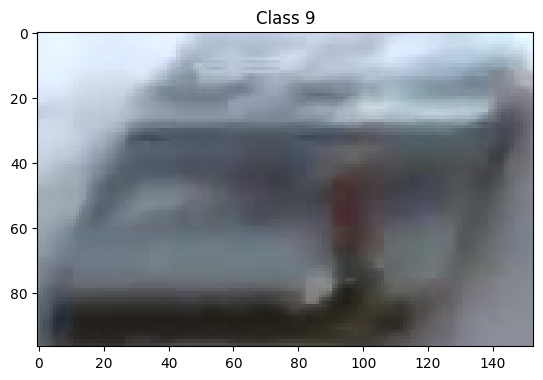

In [4]:
sample_idx = 0
roi = X[sample_idx]
plt.title(f"Class {Y[sample_idx]}")
plt.imshow(roi)
plt.show()

In [ ]:
dinov2 = generate_embeddings.load_model()
index = generate_embeddings.create_index()

for embeddings, batch_start, batch_end in generate_embeddings.get_embeddings(dinov2, X, log_performance=True):
    sample_class_ids = np.array(Y[batch_start:batch_end])
    generate_embeddings.add_embeddings_to_index(index, embeddings, sample_class_ids)

generate_embeddings.write_index(index, Path("notebooks/analysis-pipeline/data/embeddings.index"))

Generated 5663 embeddings at 636.19 samples per second
